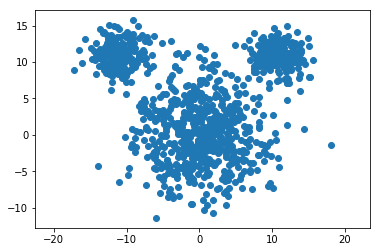

In [256]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

gauss1 = stats.multivariate_normal([0, 0], [[20, 0], [0, 20]])
gauss2 = stats.multivariate_normal([11, 11], [[3, 0], [0, 3]])
gauss3 = stats.multivariate_normal([-11, 11], [[3, 0], [0, 3]])

dataset = []
for _ in range(600):
    dataset.append(gauss1.rvs())
for _ in range(200):
    dataset.append(gauss2.rvs())
for _ in range(200):
    dataset.append(gauss3.rvs())
dataset = np.array(dataset)

fig, ax = plt.subplots(1, 1)
plt.axis('equal')
ax.scatter(x=dataset[:,0], y=dataset[:,1])
plt.show()

In [257]:
def visualize(clustering, dataset, colors):
    Y = clustering.predict(dataset)
    fig, ax = plt.subplots(1, 1)
    plt.axis('equal')
    
    clusters = dataset[:, :, None]*Y[:,None,:]
    clusters = np.transpose(clusters, (2, 1, 0))
    
    for index, cluster in enumerate(clusters):
        x = [n for i, n in enumerate(cluster[0]) if not(cluster[0][i] == cluster[1][i] == 0)]
        y = [n for i, n in enumerate(cluster[1]) if not(cluster[0][i] == cluster[1][i] == 0)]
        ax.scatter(x, y, c=colors[index])
    plt.show()

# K-means

In [258]:
import random as rand
import numpy.linalg as ling


class K_means():
    
    def __init__(self, dataset, k):
        self.centers = np.array(rand.choices(dataset, k = k))
        
        new_centers = np.ones_like(self.centers) * np.inf
        while np.any(ling.norm(self.centers - new_centers, axis=1) > .001):
            new_centers = np.array(self.centers)
            r = dataset[None,:,:] - self.centers[:,None,:]
            r = np.sum(r**2, axis=2)
            r = (np.min(r, axis=0) >= r).astype(int)
            self.centers = r@dataset/np.sum(r, axis=1)[:, None]
            
    def predict(self, X):
        Y = X[None,:,:] - self.centers[:,None,:]
        Y = np.sum(Y**2, axis=2)
        return (np.min(Y, axis=0) >= Y).astype(int).T

# Gaussian Mixture Model

In [259]:
import numpy.linalg as ling
import scipy.stats as stats


class GMM():
    
    def _set_sigma(cluster, mi):
        temp = cluster - mi[:, None]
        temp = np.tile(temp, (temp.shape[0], 1, 1))
        temp = temp * temp.transpose((1, 0, 2))
        return np.sum(temp, axis =2)/cluster.shape[1]
    
    
    def _stop_condiction(self, predict, dataset):
        return np.any(predict - self.predict(dataset)) != 0
    
            
    def __init__(self, dataset, k, epsilon = .1, max_itr = 200):
        self.k = k
        
        #K-means
        first_predict = K_means(dataset, k)
        predict = first_predict.predict(dataset).T 
        clusters = predict[:,:, None] * dataset[None,:,:]
        clusters = list(np.transpose(clusters, (0, 2, 1)))
        clusters = [cluster[:, cluster[1] + cluster[0]+ cluster[1]*cluster[0] != 0] \
                    for cluster in clusters]
        predict = predict.T
        
        #Inicjalizacja
        self.mi = [np.sum(cluster, axis=1)/cluster.shape[1] for cluster in clusters]
        self.sigma = []
        for cluster, mi_ in zip(clusters, self.mi):
            self.sigma.append(GMM._set_sigma(cluster, mi_))
        self.pi = [cluster.shape[1]/dataset.shape[0] for cluster in clusters]
        
        #Poszukiwanie rozwiązania
        itr = 0
        while itr < max_itr and (self._stop_condiction(predict, dataset)):
            predict = self.predict(dataset)
            itr += 1
            r = []
            for i in range(k):
                r.append(self.pi[i] * stats.multivariate_normal.pdf(dataset, mean=self.mi[i], \
                                                                    cov=self.sigma[i]))
            r = [r_/sum(r) for r_ in r]
            
            for i in range(k):
                N = np.sum(r[i])
                self.mi[i] = np.sum(r[i][:,None]*dataset, axis=0)/N
                temp = dataset.T - self.mi[i][:, None]
                temp = np.tile(temp, (temp.shape[0], 1, 1))
                temp = temp * temp.transpose((1, 0, 2))
                self.sigma[i] = np.sum(r[i]*temp, axis =2)/N
                self.pi[i] = N/dataset.shape[0]
                
                #W przypadku pojawienia się zdegenerowanych wartości robimy reset
                if np.all(self.sigma[i] < epsilon):
                    self.mi[i] = rand.choise(clusters[i])
                    self.sigma[i] = GMM._set_sigma(clusters[i], self.mi[i])
                    self.pi[i] = np.sum(r[i])/dataset.shape[0]
                    
        
    def predict(self, X):
        Y = [stats.multivariate_normal.pdf(X, self.mi[i], self.sigma[i]) for i in range(self.k)]
        Y = np.array(Y)                                       
        return (np.max(Y, axis=0) <= Y).astype(int).T

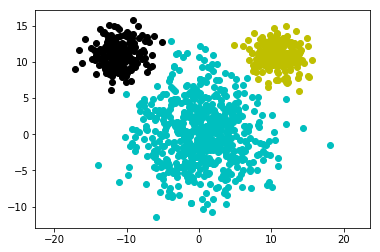

[array([-11.07172361,  11.08224879]), array([0.34922477, 0.2143722 ]), array([10.87794988, 10.87580465])]
[array([[3.84153812, 0.14120518],
       [0.14120518, 2.9633052 ]]), array([[20.14396222, -0.05003561],
       [-0.05003561, 19.42331307]]), array([[ 3.72069582, -0.27918317],
       [-0.27918317,  2.6416737 ]])]
[0.19934980055043397, 0.6016899767043589, 0.1989602227452072]


In [262]:
a =GMM(dataset, 3)
visualize(a, dataset, ['k', 'c', 'y'])

print(a.mi)
print(a.sigma)
print(a.pi)

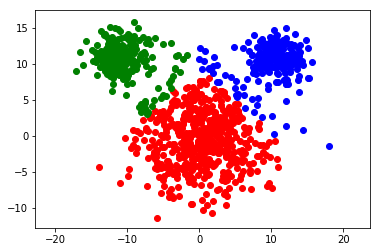

[[  0.27093136  -0.66584271]
 [-10.36319319  10.56288193]
 [ 10.02633574  10.19837059]]


In [263]:
k = K_means(dataset, 3)
visualize(k, dataset, ['r', 'g', 'b'])
print(k.centers)